# Convergence of cG(r)-cG(r) all-at-once scheme for exponential growth and harmonic oscillator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.sparse import dok_matrix
from scipy.sparse.linalg import spsolve

In [2]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

## Solve the exponential growth ODE with all-at-once cG(r)-cG(r) in FEniCS

--------------
|   r = 1   |
--------------
--------------
|   r = 2   |
--------------
--------------
|   r = 3   |
--------------
--------------
|   r = 4   |
--------------
--------------
|   r = 5   |
--------------
--------------
|   r = 6   |
--------------
Final time error
Slope for cG(1)-cG(1): 1.9694630855293886
(1.0,1.2817181715409576)(0.5,0.13933446003799155)(0.25,0.03825930804992339)(0.125,0.009805213821675096)(0.0625,0.002466792079113933)(0.03125,0.0006176735538860889)(0.015625,0.000154479477417091)(0.0078125,3.862368925489079e-05)
Slope for cG(2)-cG(2): 1.9958163742706923
(1.0,0.0819181920954084)(0.5,0.02152057881731473)(0.25,0.005450594561538402)(0.125,0.001367142282992173)(0.0625,0.0003420678647310105)(0.03125,8.553463240890125e-05)(0.015625,2.13847626615582e-05)(0.0078125,5.346263759253844e-06)
Slope for cG(3)-cG(3): 3.9934847273642156
(1.0,0.005856102575434452)(0.5,0.0002084291382704606)(0.25,1.3378011579856519e-05)(0.125,8.417673185157071e-07)(0.0625,5.26989269999944

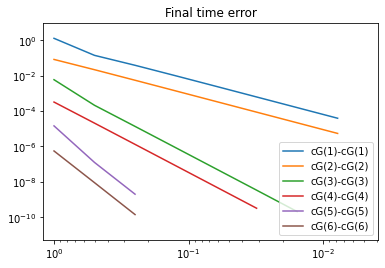

L2-norm error
Slope for cG(1)-cG(1): 2.136330146024259
(1.0,0.8706030906819471)(0.5,0.098855874416405)(0.25,0.027160372651062598)(0.125,0.006961616665672667)(0.0625,0.0017514534344348928)(0.03125,0.00043855924768410347)(0.015625,0.00010968338863083587)(0.0078125,2.742357201081571e-05)
Slope for cG(2)-cG(2): 1.9858249349766162
(1.0,0.054421162724982396)(0.5,0.014316053301777567)(0.25,0.003627116809617876)(0.125,0.0009098474199727456)(0.0625,0.000227654601218612)(0.03125,5.6925712568369925e-05)(0.015625,1.4232182326072956e-05)(0.0078125,3.558096441888087e-06)
Slope for cG(3)-cG(3): 4.1186858134834985
(1.0,0.0038885899375040904)(0.5,0.00014412391930475175)(0.25,9.257645720830063e-06)(0.125,5.826188313203623e-07)(0.0625,3.647674922036326e-08)(0.03125,2.2810335544079754e-09)(0.015625,1.4148301712489118e-10)
Slope for cG(4)-cG(4): 3.9910312450617464
(1.0,0.00021079794428843454)(0.5,1.3524968312421695e-05)(0.25,8.508986519109821e-07)(0.125,5.326892259111818e-08)(0.0625,3.330721257152112e-09)(

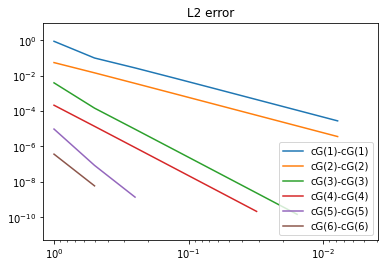

In [3]:
from fenics import *
import matplotlib.pyplot as plt
import math

set_log_active(False) # turn off FEniCS logging

# define temporal mesh
t0 = 0. # start time
T = 1. # end time
error = {"final": {}, "L2": {}}

for r in range(1,7):
    print("--------------")
    print(f"|   r = {r}   |")
    print("--------------")
    
    error["final"][r] = []
    error["L2"][r] = []
    
    for n_time in [np.power(2,i) for i in range(8)]:
        mesh = IntervalMesh(n_time, t0, T)
        V = FunctionSpace(mesh, 'P', r)

        # Analytical solution U is used as Dirichlet BC
        U = Expression('exp(x[0])', degree=2*r+3)
        initial_time = "near(x[0], 0) && on_boundary"
        ic = DirichletBC(V, Constant(1.), initial_time)

        # Define variational problem
        f = Constant(0.)
        u = TrialFunction(V)
        v = TestFunction(V)
        a = grad(u)[0]*v*dx - u*v*dx
        L = f*v*dx

        # Solve
        u_k = Function(V)
        solve(a == L, u_k, ic)

        k = (T - t0) / n_time
        error["final"][r].append([k, np.abs(U(1.) - u_k(1.))])
        error["L2"][r].append([k, errornorm(U, u_k, 'L2')])
        
print("Final time error")
plt.title("Final time error")
for r in error["final"].keys():
    k_vals = [e[0] for e in error["final"][r] if e[1] > 1e-10]
    err_vals = [e[1] for e in error["final"][r] if e[1] > 1e-10]
    if len(k_vals) > 1:
        x = k_vals
        y = err_vals
        plt.plot(x, y, label=f"cG({r})-cG({r})")
        plt.axis([1.2, pow(0.5, 8), 5e-12, 1e1])
        print(f"Slope for cG({r})-cG({r}): {(np.log(y[-1]) - np.log(y[1])) / (np.log(x[-1]) - np.log(x[1]))}")
        for _k, _e in zip(k_vals, err_vals):
            print(f"({_k},{_e})",end="")
        print("")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()

print("L2-norm error")
plt.title("L2 error")
for r in error["L2"].keys():
    k_vals = [e[0] for e in error["L2"][r] if e[1] > 1e-10]
    err_vals = [e[1] for e in error["L2"][r] if e[1] > 1e-10]
    if len(k_vals) > 1:
        x = k_vals
        y = err_vals
        plt.plot(x, y, label=f"cG({r})-cG({r})")
        plt.axis([1.2, pow(0.5, 8), 5e-12, 1e1])
        print(f"Slope for cG({r})-cG({r}): {(np.log(y[-1]) - np.log(y[0])) / (np.log(x[-1]) - np.log(x[0]))}")
        for _k, _e in zip(k_vals, err_vals):
            print(f"({_k},{_e})",end="")
        print("")
plt.legend(loc="lower right")
plt.xscale("log")
plt.yscale("log")
plt.show()

#print(error["L2"][1])
#print(error["L2"][2])

## Solve the simple harmonic oscillator ODE with all-at-once cG(r)-cG(r) in FEniCS

--------------
|   r = 1   |
--------------
--------------
|   r = 2   |
--------------
--------------
|   r = 3   |
--------------
--------------
|   r = 4   |
--------------
--------------
|   r = 5   |
--------------
--------------
|   r = 6   |
--------------
L2-norm error
Slope for cG(1)-cG(1): 1.872255422510075
Slope for cG(2)-cG(2): 2.0937978908092028
Slope for cG(3)-cG(3): 4.272146905039835
Slope for cG(4)-cG(4): 4.108729150719612
Slope for cG(5)-cG(5): 6.585830585524541
Slope for cG(6)-cG(6): 6.211114846988396


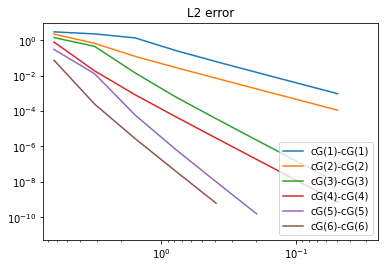

In [4]:
# define temporal mesh
t0 = 0. # start time
T = 2. * np.pi # end time
error = {"final": {}, "L2": {}}

for r in range(1,7):
    print("--------------")
    print(f"|   r = {r}   |")
    print("--------------")
    
    error["final"][r] = []
    error["L2"][r] = []
    
    for n_time in [np.power(2,i) for i in range(8)]:
        mesh = IntervalMesh(n_time, t0, T)
        element = {
            "u": VectorElement("Lagrange", mesh.ufl_cell(), r),
            "v": FiniteElement("Lagrange", mesh.ufl_cell(), r),
        }
        V = FunctionSpace(mesh, MixedElement(*element.values()))

        # Analytical solution U is used as Dirichlet BC
        U_analytical = Expression(('sin(x[0])', 'cos(x[0])'), degree=2*r+3)
        initial_time = "near(x[0], 0) && on_boundary"
        ic = DirichletBC(V, Constant((0., 1.)), initial_time)

        # Define variational problem
        f_u = Constant(0.)
        f_v = Constant(0.)
        U = TrialFunction(V)
        Phi = TestFunction(V)
                          
        #print(shape(grad(u)))
        a_u = U[1].dx(0)*Phi[0]*dx + U[0]*Phi[0]*dx
        a_v = U[0].dx(0)*Phi[1]*dx - U[1]*Phi[1]*dx
        L_u = f_u*Phi[0]*dx
        L_v = f_v*Phi[1]*dx

        # Solve
        U_k = Function(V)
        solve(a_u + a_v == L_u + L_v, U_k, ic)

        k = (T - t0) / n_time
        _error = errornorm(U_analytical, U_k, 'L2')
        _error = sqrt(assemble((U_analytical[0]-U_k[0])*(U_analytical[0]-U_k[0])*dx + (U_analytical[1]-U_k[1])*(U_analytical[1]-U_k[1])*dx))
        error["L2"][r].append([k, _error])

print("L2-norm error")
plt.title("L2 error")
for r in error["L2"].keys():
    k_vals = [e[0] for e in error["L2"][r] if e[1] > 1e-10]
    err_vals = [e[1] for e in error["L2"][r] if e[1] > 1e-10]
    if len(k_vals) > 1:
        x = k_vals
        y = err_vals
        plt.plot(x, y, label=f"cG({r})-cG({r})")
        plt.axis([2*np.pi*1.2, 2*np.pi*pow(0.5, 8), 5e-12, 1e1])
        print(f"Slope for cG({r})-cG({r}): {(np.log(y[-1]) - np.log(y[1])) / (np.log(x[-1]) - np.log(x[1]))}")
plt.legend(loc="lower right")
plt.xscale("log")
plt.yscale("log")
plt.show()

# Solve the exponential growth ODE with all-at-once dG(r) in FEniCS

--------------
|   r = 1   |
--------------
0 in interior_facets: False
0.5 in interior_facets: True
1 in interior_facets: False


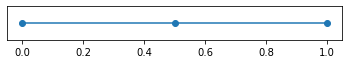

Jumps:  [[ 0.  0. -0. -0.]
 [ 0.  1. -1. -0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
Jumps 2:  [[ 0.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [-0. -1.  0.  0.]
 [-0. -0.  0.  0.]]
Jumps 3:  [[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [-0. -1.  1.  0.]
 [-0. -0.  0.  0.]]
0 : [0.]
1 : [0.5]
2 : [0.5]
3 : [1.]
[[-0.66666667  0.41666667  0.          0.        ]
 [-0.58333333  0.33333333  0.          0.        ]
 [ 0.          0.         -0.66666667  0.41666667]
 [ 0.          0.         -0.58333333  0.33333333]]
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [-0. -1.  1.  0.]
 [-0. -0.  0.  0.]]
[[ 0.33333333  0.41666667  0.          0.        ]
 [-0.58333333  0.33333333  0.          0.        ]
 [-0.         -1.          0.33333333  0.41666667]
 [-0.         -0.         -0.58333333  0.33333333]]
[0.94117647 1.64705882 1.55017301 2.71280277]
0 in interior_facets: False
0.5 in interior_facets: True
1 in interior_facets: False


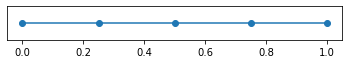

Jumps:  [[ 0.  0. -0. -0.  0.  0.  0.  0.]
 [ 0.  1. -1. -0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -0. -0.  0.  0.]
 [ 0.  0.  0.  1. -1. -0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -0. -0.]
 [ 0.  0.  0.  0.  0.  1. -1. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]
Jumps 2:  [[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [-0. -1.  0.  0.  0.  0.  0.  0.]
 [-0. -0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0. -0. -1.  0.  0.  0.  0.]
 [ 0.  0. -0. -0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0. -0. -1.  0.  0.]
 [ 0.  0.  0.  0. -0. -0.  0.  0.]]
Jumps 3:  [[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [-0. -1.  1.  0.  0.  0.  0.  0.]
 [-0. -0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -0. -1.  1.  0.  0.  0.]
 [ 0.  0. -0. -0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -0. -1.  1.  0.]
 [ 0.  0.  0.  0. -0. -0.  0.  0.]]
0 : [0.]
1 : [0.25]
2 : [0.25]
3 : [0.5]
4 : [0.5]
5 : [0.75]
6 : [0.75]
7 : [1.]
[[-0.58333333  0.45833333  0.          0.      

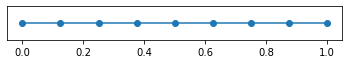

Jumps:  [[ 0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -1. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -1. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -1. -0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -1. -0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1. -0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1. -0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

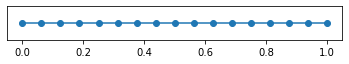

Jumps:  [[ 0.  0. -0. ...  0.  0.  0.]
 [ 0.  1. -1. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1. -1. -0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
Jumps 2:  [[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [-0. -1.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ... -0.  0.  0.]]
Jumps 3:  [[ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [-0. -1.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ... -1.  1.  0.]
 [ 0.  0.  0. ... -0.  0.  0.]]
0 : [0.]
1 : [0.0625]
2 : [0.0625]
3 : [0.125]
4 : [0.125]
5 : [0.1875]
6 : [0.1875]
7 : [0.25]
8 : [0.25]
9 : [0.3125]
10 : [0.3125]
11 : [0.375]
12 : [0.375]
13 : [0.4375]
14 : [0.4375]
15 : [0.5]
16 : [0.5]
17 : [0.5625]
18 : [0.5625]
19 : [0.625]
20 : [0.625]
21 : [0.6875]
22 : [0.6875]
23 : [0.75]
24 : [0.75]
25 : [0.8125]
26 : [0.8125]
27 : [0.875]
28 : [0.875]
29 : [0.9375]
30 : [0.9375

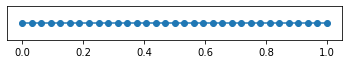

Jumps:  [[ 0.  0. -0. ...  0.  0.  0.]
 [ 0.  1. -1. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1. -1. -0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
Jumps 2:  [[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [-0. -1.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ... -0.  0.  0.]]
Jumps 3:  [[ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [-0. -1.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ... -1.  1.  0.]
 [ 0.  0.  0. ... -0.  0.  0.]]
0 : [0.]
1 : [0.03125]
2 : [0.03125]
3 : [0.0625]
4 : [0.0625]
5 : [0.09375]
6 : [0.09375]
7 : [0.125]
8 : [0.125]
9 : [0.15625]
10 : [0.15625]
11 : [0.1875]
12 : [0.1875]
13 : [0.21875]
14 : [0.21875]
15 : [0.25]
16 : [0.25]
17 : [0.28125]
18 : [0.28125]
19 : [0.3125]
20 : [0.3125]
21 : [0.34375]
22 : [0.34375]
23 : [0.375]
24 : [0.375]
25 : [0.40625]
26 : [0.40625]
27 : [0.4375]
28 : [0.4375

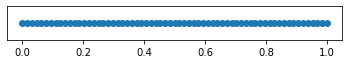

Jumps:  [[ 0.  0. -0. ...  0.  0.  0.]
 [ 0.  1. -1. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1. -1. -0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
Jumps 2:  [[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [-0. -1.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ... -0.  0.  0.]]
Jumps 3:  [[ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [-0. -1.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ... -1.  1.  0.]
 [ 0.  0.  0. ... -0.  0.  0.]]
0 : [0.]
1 : [0.015625]
2 : [0.015625]
3 : [0.03125]
4 : [0.03125]
5 : [0.046875]
6 : [0.046875]
7 : [0.0625]
8 : [0.0625]
9 : [0.078125]
10 : [0.078125]
11 : [0.09375]
12 : [0.09375]
13 : [0.109375]
14 : [0.109375]
15 : [0.125]
16 : [0.125]
17 : [0.140625]
18 : [0.140625]
19 : [0.15625]
20 : [0.15625]
21 : [0.171875]
22 : [0.171875]
23 : [0.1875]
24 : [0.1875]
25 : [0.203125]
26 : [0.203125]


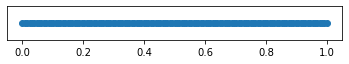

Jumps:  [[ 0.  0. -0. ...  0.  0.  0.]
 [ 0.  1. -1. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1. -1. -0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
Jumps 2:  [[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [-0. -1.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ... -0.  0.  0.]]
Jumps 3:  [[ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [-0. -1.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ... -1.  1.  0.]
 [ 0.  0.  0. ... -0.  0.  0.]]
0 : [0.]
1 : [0.0078125]
2 : [0.0078125]
3 : [0.015625]
4 : [0.015625]
5 : [0.0234375]
6 : [0.0234375]
7 : [0.03125]
8 : [0.03125]
9 : [0.0390625]
10 : [0.0390625]
11 : [0.046875]
12 : [0.046875]
13 : [0.0546875]
14 : [0.0546875]
15 : [0.0625]
16 : [0.0625]
17 : [0.0703125]
18 : [0.0703125]
19 : [0.078125]
20 : [0.078125]
21 : [0.0859375]
22 : [0.0859375]
23 : [0.09375]
24 : [0.09375]
25 : [0.

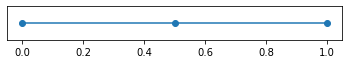

Jumps:  [[ 0.  0.  0. -0. -0.  0.]
 [ 0.  1.  0. -1. -0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
Jumps 2:  [[ 0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [-0. -1.  0.  0.  0.  0.]
 [-0. -0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
Jumps 3:  [[ 1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [-0. -1.  0.  1.  0.  0.]
 [-0. -0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
0 : [0.]
1 : [0.5]
2 : [0.25]
3 : [0.5]
4 : [1.]
5 : [0.75]
[[-0.56666667 -0.15        0.63333333  0.          0.          0.        ]
 [ 0.18333333  0.43333333 -0.7         0.          0.          0.        ]
 [-0.7         0.63333333 -0.26666667  0.          0.          0.        ]
 [ 0.          0.          0.         -0.56666667 -0.15        0.63333333]
 [ 0.          0.          0.          0.18333333  0.43333333 -0.7       ]
 [ 0.          0.          0.         -0.7      

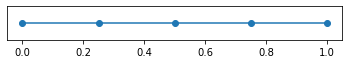

Jumps:  [[ 0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0. -1. -0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0. -1. -0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0. -1. -0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Jumps 2:  [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-0. -0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0

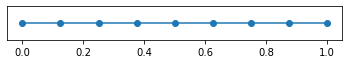

Jumps:  [[ 0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0. -1. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0. -1. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0. -1. -0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.
   0.  0.

[[ 0.48333333 -0.1625      0.65833333  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.17083333  0.48333333 -0.675       0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [-0.675       0.65833333 -0.06666667  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [-0.         -1.          0.          0.48333333 -0.1625      0.65833333
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.

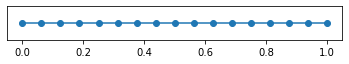

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.0625]
2 : [0.03125]
3 : [0.0625]
4 : [0.125]
5 : [0.09375]
6 : [0.125]
7 : [0.1875]
8 : [0.15625]
9 : [0.1875]
10 : [0.25]
11 : [0.21875]
12 : [0.25]
13 : [0.3125]
14 : [0.28125]
15 : [0.3125]
16 : [0.375]
17 : [0.34375]
18 : [0.375]
19 : [0.4375]
20 : [0.40625]
21 : [0.4375]
22 : [0.5]
23 : [0.46875]
24 : [0.5]
25 : [0.5625]
26 : [0.53125]
27 : [0.5625]
28 : [0.625]
29 : [0.59375]
30 : [0.625]
31 : [0.6875]
32 : [0.65625]
33 : [0.6875]
34 : [0.75]
35 : [0.71875]
36 : [0.75]
37 : [0.

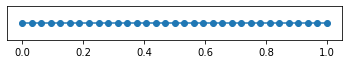

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.03125]
2 : [0.015625]
3 : [0.03125]
4 : [0.0625]
5 : [0.046875]
6 : [0.0625]
7 : [0.09375]
8 : [0.078125]
9 : [0.09375]
10 : [0.125]
11 : [0.109375]
12 : [0.125]
13 : [0.15625]
14 : [0.140625]
15 : [0.15625]
16 : [0.1875]
17 : [0.171875]
18 : [0.1875]
19 : [0.21875]
20 : [0.203125]
21 : [0.21875]
22 : [0.25]
23 : [0.234375]
24 : [0.25]
25 : [0.28125]
26 : [0.265625]
27 : [0.28125]
28 : [0.3125]
29 : [0.296875]
30 : [0.3125]
31 : [0.34375]
32 : [0.328125]
33 : [0.34375]
34 : [0.375]
3

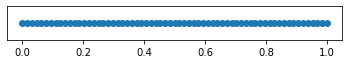

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.015625]
2 : [0.0078125]
3 : [0.015625]
4 : [0.03125]
5 : [0.0234375]
6 : [0.03125]
7 : [0.046875]
8 : [0.0390625]
9 : [0.046875]
10 : [0.0625]
11 : [0.0546875]
12 : [0.0625]
13 : [0.078125]
14 : [0.0703125]
15 : [0.078125]
16 : [0.09375]
17 : [0.0859375]
18 : [0.09375]
19 : [0.109375]
20 : [0.1015625]
21 : [0.109375]
22 : [0.125]
23 : [0.1171875]
24 : [0.125]
25 : [0.140625]
26 : [0.1328125]
27 : [0.140625]
28 : [0.15625]
29 : [0.1484375]
30 : [0.15625]
31 : [0.171875]
32 : [0.164062

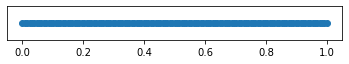

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.0078125]
2 : [0.00390625]
3 : [0.0078125]
4 : [0.015625]
5 : [0.01171875]
6 : [0.015625]
7 : [0.0234375]
8 : [0.01953125]
9 : [0.0234375]
10 : [0.03125]
11 : [0.02734375]
12 : [0.03125]
13 : [0.0390625]
14 : [0.03515625]
15 : [0.0390625]
16 : [0.046875]
17 : [0.04296875]
18 : [0.046875]
19 : [0.0546875]
20 : [0.05078125]
21 : [0.0546875]
22 : [0.0625]
23 : [0.05859375]
24 : [0.0625]
25 : [0.0703125]
26 : [0.06640625]
27 : [0.0703125]
28 : [0.078125]
29 : [0.07421875]
30 : [0.078125]


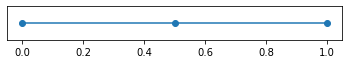

Jumps:  [[ 0.  0.  0.  0. -0. -0.  0.  0.]
 [ 0.  1.  0.  0. -1. -0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]
Jumps 2:  [[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [-0. -1.  0.  0.  0.  0.  0.  0.]
 [-0. -0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]
Jumps 3:  [[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [-0. -1.  0.  0.  1.  0.  0.  0.]
 [-0. -0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]
0 : [0.]
1 : [0.5]
2 : [0.16666667]
3 : [0.33333333]
4 : [0.5]
5 : [1.]
6 : [0.66666667]
7 : [0.83333333]
[[-0.53809524  0.081845

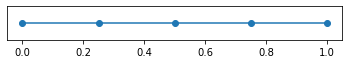

Jumps:  [[ 0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0. -1. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0. -1. -0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0. -1. -0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

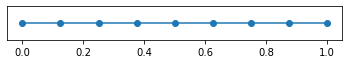

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.125]
2 : [0.04166667]
3 : [0.08333333]
4 : [0.125]
5 : [0.25]
6 : [0.16666667]
7 : [0.20833333]
8 : [0.25]
9 : [0.375]
10 : [0.29166667]
11 : [0.33333333]
12 : [0.375]
13 : [0.5]
14 : [0.41666667]
15 : [0.45833333]
16 : [0.5]
17 : [0.625]
18 : [0.54166667]
19 : [0.58333333]
20 : [0.625]
21 : [0.75]
22 : [0.66666667]
23 : [0.70833333]
24 : [0.75]
25 : [0.875]
26 : [0.79166667]
27 : [0.83333333]
28 : [0.875]
29 : [1.]
30 : [0.91666667]
31 : [0.95833333]
[[-0.50952381  0.08608631  0.705

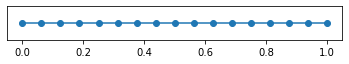

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.0625]
2 : [0.02083333]
3 : [0.04166667]
4 : [0.0625]
5 : [0.125]
6 : [0.08333333]
7 : [0.10416667]
8 : [0.125]
9 : [0.1875]
10 : [0.14583333]
11 : [0.16666667]
12 : [0.1875]
13 : [0.25]
14 : [0.20833333]
15 : [0.22916667]
16 : [0.25]
17 : [0.3125]
18 : [0.27083333]
19 : [0.29166667]
20 : [0.3125]
21 : [0.375]
22 : [0.33333333]
23 : [0.35416667]
24 : [0.375]
25 : [0.4375]
26 : [0.39583333]
27 : [0.41666667]
28 : [0.4375]
29 : [0.5]
30 : [0.45833333]
31 : [0.47916667]
32 : [0.5]
33 : [

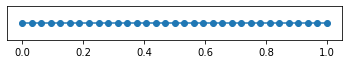

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.03125]
2 : [0.01041667]
3 : [0.02083333]
4 : [0.03125]
5 : [0.0625]
6 : [0.04166667]
7 : [0.05208333]
8 : [0.0625]
9 : [0.09375]
10 : [0.07291667]
11 : [0.08333333]
12 : [0.09375]
13 : [0.125]
14 : [0.10416667]
15 : [0.11458333]
16 : [0.125]
17 : [0.15625]
18 : [0.13541667]
19 : [0.14583333]
20 : [0.15625]
21 : [0.1875]
22 : [0.16666667]
23 : [0.17708333]
24 : [0.1875]
25 : [0.21875]
26 : [0.19791667]
27 : [0.20833333]
28 : [0.21875]
29 : [0.25]
30 : [0.22916667]
31 : [0.23958333]
32

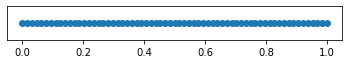

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.015625]
2 : [0.00520833]
3 : [0.01041667]
4 : [0.015625]
5 : [0.03125]
6 : [0.02083333]
7 : [0.02604167]
8 : [0.03125]
9 : [0.046875]
10 : [0.03645833]
11 : [0.04166667]
12 : [0.046875]
13 : [0.0625]
14 : [0.05208333]
15 : [0.05729167]
16 : [0.0625]
17 : [0.078125]
18 : [0.06770833]
19 : [0.07291667]
20 : [0.078125]
21 : [0.09375]
22 : [0.08333333]
23 : [0.08854167]
24 : [0.09375]
25 : [0.109375]
26 : [0.09895833]
27 : [0.10416667]
28 : [0.109375]
29 : [0.125]
30 : [0.11458333]
31 : 

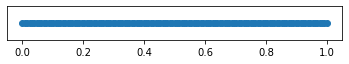

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.0078125]
2 : [0.00260417]
3 : [0.00520833]
4 : [0.0078125]
5 : [0.015625]
6 : [0.01041667]
7 : [0.01302083]
8 : [0.015625]
9 : [0.0234375]
10 : [0.01822917]
11 : [0.02083333]
12 : [0.0234375]
13 : [0.03125]
14 : [0.02604167]
15 : [0.02864583]
16 : [0.03125]
17 : [0.0390625]
18 : [0.03385417]
19 : [0.03645833]
20 : [0.0390625]
21 : [0.046875]
22 : [0.04166667]
23 : [0.04427083]
24 : [0.046875]
25 : [0.0546875]
26 : [0.04947917]
27 : [0.05208333]
28 : [0.0546875]
29 : [0.0625]
30 : [0.

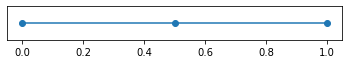

Jumps:  [[ 0.  0.  0.  0.  0. -0. -0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0. -1. -0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Jumps 2:  [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-0. -0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Jumps 3:  [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0

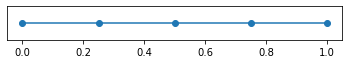

Jumps:  [[ 0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  1.  0.  0.  0. -1. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -1. -0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.

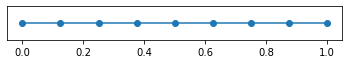

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.125]
2 : [0.03125]
3 : [0.0625]
4 : [0.09375]
5 : [0.125]
6 : [0.25]
7 : [0.15625]
8 : [0.1875]
9 : [0.21875]
10 : [0.25]
11 : [0.375]
12 : [0.28125]
13 : [0.3125]
14 : [0.34375]
15 : [0.375]
16 : [0.5]
17 : [0.40625]
18 : [0.4375]
19 : [0.46875]
20 : [0.5]
21 : [0.625]
22 : [0.53125]
23 : [0.5625]
24 : [0.59375]
25 : [0.625]
26 : [0.75]
27 : [0.65625]
28 : [0.6875]
29 : [0.71875]
30 : [0.75]
31 : [0.875]
32 : [0.78125]
33 : [0.8125]
34 : [0.84375]
35 : [0.875]
36 : [1.]
37 : [0.9062

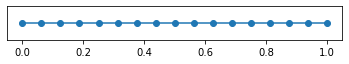

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.0625]
2 : [0.015625]
3 : [0.03125]
4 : [0.046875]
5 : [0.0625]
6 : [0.125]
7 : [0.078125]
8 : [0.09375]
9 : [0.109375]
10 : [0.125]
11 : [0.1875]
12 : [0.140625]
13 : [0.15625]
14 : [0.171875]
15 : [0.1875]
16 : [0.25]
17 : [0.203125]
18 : [0.21875]
19 : [0.234375]
20 : [0.25]
21 : [0.3125]
22 : [0.265625]
23 : [0.28125]
24 : [0.296875]
25 : [0.3125]
26 : [0.375]
27 : [0.328125]
28 : [0.34375]
29 : [0.359375]
30 : [0.375]
31 : [0.4375]
32 : [0.390625]
33 : [0.40625]
34 : [0.421875]
3

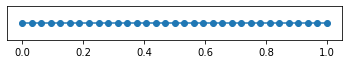

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.03125]
2 : [0.0078125]
3 : [0.015625]
4 : [0.0234375]
5 : [0.03125]
6 : [0.0625]
7 : [0.0390625]
8 : [0.046875]
9 : [0.0546875]
10 : [0.0625]
11 : [0.09375]
12 : [0.0703125]
13 : [0.078125]
14 : [0.0859375]
15 : [0.09375]
16 : [0.125]
17 : [0.1015625]
18 : [0.109375]
19 : [0.1171875]
20 : [0.125]
21 : [0.15625]
22 : [0.1328125]
23 : [0.140625]
24 : [0.1484375]
25 : [0.15625]
26 : [0.1875]
27 : [0.1640625]
28 : [0.171875]
29 : [0.1796875]
30 : [0.1875]
31 : [0.21875]
32 : [0.1953125]


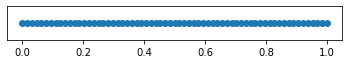

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.015625]
2 : [0.00390625]
3 : [0.0078125]
4 : [0.01171875]
5 : [0.015625]
6 : [0.03125]
7 : [0.01953125]
8 : [0.0234375]
9 : [0.02734375]
10 : [0.03125]
11 : [0.046875]
12 : [0.03515625]
13 : [0.0390625]
14 : [0.04296875]
15 : [0.046875]
16 : [0.0625]
17 : [0.05078125]
18 : [0.0546875]
19 : [0.05859375]
20 : [0.0625]
21 : [0.078125]
22 : [0.06640625]
23 : [0.0703125]
24 : [0.07421875]
25 : [0.078125]
26 : [0.09375]
27 : [0.08203125]
28 : [0.0859375]
29 : [0.08984375]
30 : [0.09375]
31

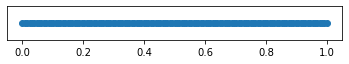

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.0078125]
2 : [0.00195312]
3 : [0.00390625]
4 : [0.00585938]
5 : [0.0078125]
6 : [0.015625]
7 : [0.00976562]
8 : [0.01171875]
9 : [0.01367188]
10 : [0.015625]
11 : [0.0234375]
12 : [0.01757812]
13 : [0.01953125]
14 : [0.02148438]
15 : [0.0234375]
16 : [0.03125]
17 : [0.02539062]
18 : [0.02734375]
19 : [0.02929688]
20 : [0.03125]
21 : [0.0390625]
22 : [0.03320312]
23 : [0.03515625]
24 : [0.03710938]
25 : [0.0390625]
26 : [0.046875]
27 : [0.04101562]
28 : [0.04296875]
29 : [0.04492188]


[[-0.50040234 -0.0565738   0.77842813 ...  0.          0.
   0.        ]
 [ 0.05665371  0.49959766 -0.20325176 ...  0.          0.
   0.        ]
 [-0.77924383  0.20309744 -0.00246914 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.00246914  1.11798942
  -0.54215168]
 [ 0.          0.          0.         ... -1.11693122 -0.00257937
   1.11798942]
 [ 0.          0.          0.         ...  0.54144621 -1.11693122
  -0.00246914]]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 0.49959766 -0.0565738   0.77842813 ...  0.          0.
   0.        ]
 [ 0.05665371  0.49959766 -0.20325176 ...  0.          0.
   0.        ]
 [-0.77924383  0.20309744 -0.00246914 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.00246914  1.11798942
  -0.54215168]
 [ 0.          0.          0.         ... -1.11693122 -0.00257937
   1.

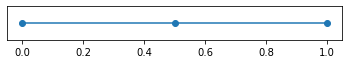

Jumps:  [[ 0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0. -1. -0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Jumps 2:  [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-0. -0.  0

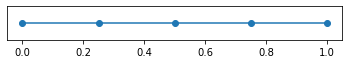

Jumps:  [[ 0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0. -1. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0. -1. -0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.

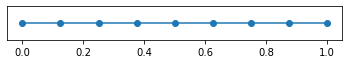

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.125]
2 : [0.025]
3 : [0.05]
4 : [0.075]
5 : [0.1]
6 : [0.125]
7 : [0.25]
8 : [0.15]
9 : [0.175]
10 : [0.2]
11 : [0.225]
12 : [0.25]
13 : [0.375]
14 : [0.275]
15 : [0.3]
16 : [0.325]
17 : [0.35]
18 : [0.375]
19 : [0.5]
20 : [0.4]
21 : [0.425]
22 : [0.45]
23 : [0.475]
24 : [0.5]
25 : [0.625]
26 : [0.525]
27 : [0.55]
28 : [0.575]
29 : [0.6]
30 : [0.625]
31 : [0.75]
32 : [0.65]
33 : [0.675]
34 : [0.7]
35 : [0.725]
36 : [0.75]
37 : [0.875]
38 : [0.775]
39 : [0.8]
40 : [0.825]
41 : [0.85]


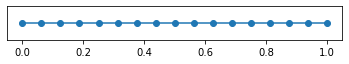

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.0625]
2 : [0.0125]
3 : [0.025]
4 : [0.0375]
5 : [0.05]
6 : [0.0625]
7 : [0.125]
8 : [0.075]
9 : [0.0875]
10 : [0.1]
11 : [0.1125]
12 : [0.125]
13 : [0.1875]
14 : [0.1375]
15 : [0.15]
16 : [0.1625]
17 : [0.175]
18 : [0.1875]
19 : [0.25]
20 : [0.2]
21 : [0.2125]
22 : [0.225]
23 : [0.2375]
24 : [0.25]
25 : [0.3125]
26 : [0.2625]
27 : [0.275]
28 : [0.2875]
29 : [0.3]
30 : [0.3125]
31 : [0.375]
32 : [0.325]
33 : [0.3375]
34 : [0.35]
35 : [0.3625]
36 : [0.375]
37 : [0.4375]
38 : [0.3875]
3

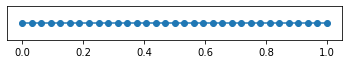

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.03125]
2 : [0.00625]
3 : [0.0125]
4 : [0.01875]
5 : [0.025]
6 : [0.03125]
7 : [0.0625]
8 : [0.0375]
9 : [0.04375]
10 : [0.05]
11 : [0.05625]
12 : [0.0625]
13 : [0.09375]
14 : [0.06875]
15 : [0.075]
16 : [0.08125]
17 : [0.0875]
18 : [0.09375]
19 : [0.125]
20 : [0.1]
21 : [0.10625]
22 : [0.1125]
23 : [0.11875]
24 : [0.125]
25 : [0.15625]
26 : [0.13125]
27 : [0.1375]
28 : [0.14375]
29 : [0.15]
30 : [0.15625]
31 : [0.1875]
32 : [0.1625]
33 : [0.16875]
34 : [0.175]
35 : [0.18125]
36 : [0.

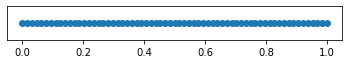

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.015625]
2 : [0.003125]
3 : [0.00625]
4 : [0.009375]
5 : [0.0125]
6 : [0.015625]
7 : [0.03125]
8 : [0.01875]
9 : [0.021875]
10 : [0.025]
11 : [0.028125]
12 : [0.03125]
13 : [0.046875]
14 : [0.034375]
15 : [0.0375]
16 : [0.040625]
17 : [0.04375]
18 : [0.046875]
19 : [0.0625]
20 : [0.05]
21 : [0.053125]
22 : [0.05625]
23 : [0.059375]
24 : [0.0625]
25 : [0.078125]
26 : [0.065625]
27 : [0.06875]
28 : [0.071875]
29 : [0.075]
30 : [0.078125]
31 : [0.09375]
32 : [0.08125]
33 : [0.084375]
34 

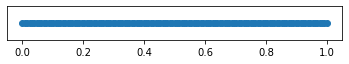

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.0078125]
2 : [0.0015625]
3 : [0.003125]
4 : [0.0046875]
5 : [0.00625]
6 : [0.0078125]
7 : [0.015625]
8 : [0.009375]
9 : [0.0109375]
10 : [0.0125]
11 : [0.0140625]
12 : [0.015625]
13 : [0.0234375]
14 : [0.0171875]
15 : [0.01875]
16 : [0.0203125]
17 : [0.021875]
18 : [0.0234375]
19 : [0.03125]
20 : [0.025]
21 : [0.0265625]
22 : [0.028125]
23 : [0.0296875]
24 : [0.03125]
25 : [0.0390625]
26 : [0.0328125]
27 : [0.034375]
28 : [0.0359375]
29 : [0.0375]
30 : [0.0390625]
31 : [0.046875]
32 

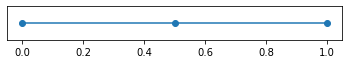

Jumps:  [[ 0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0. -1. -0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Jumps 2:  [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.

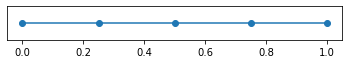

Jumps:  [[ 0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0. -1. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0

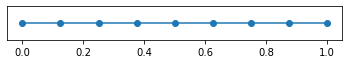

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.125]
2 : [0.02083333]
3 : [0.04166667]
4 : [0.0625]
5 : [0.08333333]
6 : [0.10416667]
7 : [0.125]
8 : [0.25]
9 : [0.14583333]
10 : [0.16666667]
11 : [0.1875]
12 : [0.20833333]
13 : [0.22916667]
14 : [0.25]
15 : [0.375]
16 : [0.27083333]
17 : [0.29166667]
18 : [0.3125]
19 : [0.33333333]
20 : [0.35416667]
21 : [0.375]
22 : [0.5]
23 : [0.39583333]
24 : [0.41666667]
25 : [0.4375]
26 : [0.45833333]
27 : [0.47916667]
28 : [0.5]
29 : [0.625]
30 : [0.52083333]
31 : [0.54166667]
32 : [0.5625]

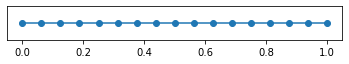

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.0625]
2 : [0.01041667]
3 : [0.02083333]
4 : [0.03125]
5 : [0.04166667]
6 : [0.05208333]
7 : [0.0625]
8 : [0.125]
9 : [0.07291667]
10 : [0.08333333]
11 : [0.09375]
12 : [0.10416667]
13 : [0.11458333]
14 : [0.125]
15 : [0.1875]
16 : [0.13541667]
17 : [0.14583333]
18 : [0.15625]
19 : [0.16666667]
20 : [0.17708333]
21 : [0.1875]
22 : [0.25]
23 : [0.19791667]
24 : [0.20833333]
25 : [0.21875]
26 : [0.22916667]
27 : [0.23958333]
28 : [0.25]
29 : [0.3125]
30 : [0.26041667]
31 : [0.27083333]


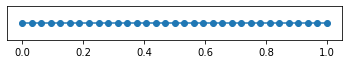

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.03125]
2 : [0.00520833]
3 : [0.01041667]
4 : [0.015625]
5 : [0.02083333]
6 : [0.02604167]
7 : [0.03125]
8 : [0.0625]
9 : [0.03645833]
10 : [0.04166667]
11 : [0.046875]
12 : [0.05208333]
13 : [0.05729167]
14 : [0.0625]
15 : [0.09375]
16 : [0.06770833]
17 : [0.07291667]
18 : [0.078125]
19 : [0.08333333]
20 : [0.08854167]
21 : [0.09375]
22 : [0.125]
23 : [0.09895833]
24 : [0.10416667]
25 : [0.109375]
26 : [0.11458333]
27 : [0.11979167]
28 : [0.125]
29 : [0.15625]
30 : [0.13020833]
31 : 

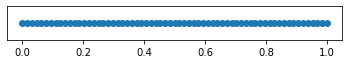

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.015625]
2 : [0.00260417]
3 : [0.00520833]
4 : [0.0078125]
5 : [0.01041667]
6 : [0.01302083]
7 : [0.015625]
8 : [0.03125]
9 : [0.01822917]
10 : [0.02083333]
11 : [0.0234375]
12 : [0.02604167]
13 : [0.02864583]
14 : [0.03125]
15 : [0.046875]
16 : [0.03385417]
17 : [0.03645833]
18 : [0.0390625]
19 : [0.04166667]
20 : [0.04427083]
21 : [0.046875]
22 : [0.0625]
23 : [0.04947917]
24 : [0.05208333]
25 : [0.0546875]
26 : [0.05729167]
27 : [0.05989583]
28 : [0.0625]
29 : [0.078125]
30 : [0.06

[1.         1.01574771 1.00260756 1.00522192 1.0078431  1.01047111
 1.01310597 1.01574771 1.03174341 1.01839633 1.02105186 1.02371432
 1.02638371 1.02906007 1.03174341 1.047991   1.03443374 1.03713109
 1.03983547 1.04254691 1.04526541 1.047991   1.06449446 1.0507237
 1.05346353 1.0562105  1.05896463 1.06172594 1.06449446 1.08125781
 1.06727019 1.07005316 1.07284339 1.0756409  1.0784457  1.08125781
 1.09828514 1.08407725 1.08690405 1.08973822 1.09257978 1.09542874
 1.09828514 1.11558061 1.10114899 1.1040203  1.1068991  1.1097854
 1.11267924 1.11558061 1.13314845 1.11848956 1.12140609 1.12433022
 1.12726198 1.13020138 1.13314845 1.15099294 1.13610321 1.13906566
 1.14203585 1.14501377 1.14799947 1.15099294 1.16911845 1.15399423
 1.15700334 1.16002029 1.16304512 1.16607783 1.16911845 1.18752938
 1.17216699 1.17522349 1.17828796 1.18136041 1.18444088 1.18752938
 1.20623025 1.19062594 1.19373057 1.19684329 1.19996413 1.20309311
 1.20623025 1.22522561 1.20937557 1.21252909 1.21569083 1.218860

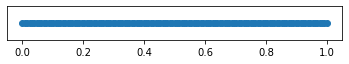

Jumps:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 2:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Jumps 3:  [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 : [0.]
1 : [0.0078125]
2 : [0.00130208]
3 : [0.00260417]
4 : [0.00390625]
5 : [0.00520833]
6 : [0.00651042]
7 : [0.0078125]
8 : [0.015625]
9 : [0.00911458]
10 : [0.01041667]
11 : [0.01171875]
12 : [0.01302083]
13 : [0.01432292]
14 : [0.015625]
15 : [0.0234375]
16 : [0.01692708]
17 : [0.01822917]
18 : [0.01953125]
19 : [0.02083333]
20 : [0.02213542]
21 : [0.0234375]
22 : [0.03125]
23 : [0.02473958]
24 : [0.02604167]
25 : [0.02734375]
26 : [0.02864583]
27 : [0.02994792]
28 : [0.03125]
29 : [0.039062

/tmp/ipykernel_15850/1360233331.py:115: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Slope for dG({r}): {(np.log(y[-1]) - np.log(y[1])) / (np.log(x[-1]) - np.log(x[1]))}")


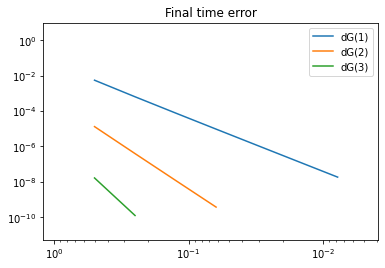

L2-norm error
Slope for dG(1): 2.016279610748216
Slope for dG(2): 3.008088773053004
Slope for dG(3): 4.006058520005028
Slope for dG(4): 5.003189787974026
Slope for dG(5): 5.996920271212073


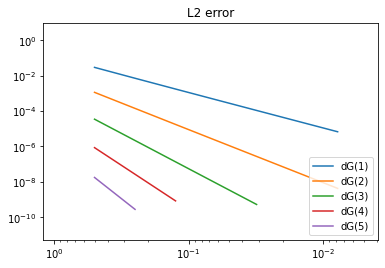

In [16]:
parameters["reorder_dofs_serial"] = False

# define temporal mesh
t0 = 0. # start time
T = 1. # end time
error = {"final": {}, "L2": {}}

for r in range(1,7):
    print("--------------")
    print(f"|   r = {r}   |")
    print("--------------")
    
    error["final"][r] = []
    error["L2"][r] = []
    
    for n_time in [np.power(2,i) for i in range(1,8)]:
        mesh = IntervalMesh(n_time, t0, T)
        V = FunctionSpace(mesh, 'DG', r)

        # Analytical solution U is used as Dirichlet BC
        U = Expression('exp(x[0])', degree=2*r+3)
        initial_time = CompiledSubDomain("near(x[0], 0) && on_boundary")
        interior_facets = CompiledSubDomain("!on_boundary") #CompiledSubDomain("near(x[0], 0.5) && !on_boundary")
        #print("0 in initial_time:", initial_time.inside(np.array([0.]), True))
        #print("1 in initial_time:", initial_time.inside(np.array([1.]), True))
        print("0 in interior_facets:", interior_facets.inside(np.array([0.]), True))
        print("0.5 in interior_facets:", interior_facets.inside(np.array([0.5]), False))
        print("1 in interior_facets:", interior_facets.inside(np.array([1.]), True))
        u0 = Constant(1.)
        boundary_marker = MeshFunction("size_t", mesh, 0)
        boundary_marker.set_all(0)
        initial_time.mark(boundary_marker, 1)
        interior_facets.mark(boundary_marker, 2)
        plot(mesh)
        plot(boundary_marker)
        plt.show()
        d0 = Measure('ds', domain=mesh, subdomain_data=boundary_marker, subdomain_id=1)
        d_interior = Measure('dS', domain=mesh, subdomain_data=boundary_marker, subdomain_id=2)

        # Define variational problem
        f = Constant(0.)
        u = TrialFunction(V)
        v = TestFunction(V)
        a = grad(u)[0]*v*dx - u*v*dx
        #a_jumps = jump(u)*v('+')*d_interior  + u('+')*v('+')*d0
        a_jumps = (u('+')-u('-'))*v('+')*d_interior  #u('+')*v('+')*dS  + u('+')*v('+')*d0
        a_jumps2 = (v('+')-v('-'))*u('+')*d_interior
        a_jumps3 = -u('+')*v('-')*d_interior + u('-')*v('-')*d_interior +  u('+')*v('+')*d0
        #a_jumps_2 = u('+')*v('+')*dS - u('-')*v('+')*dS + u('+')*v('+')*d0
        L = f*v*dx + u0*v('+')*d0
        
        #print(assemble(grad(u)[0]*v*dx).array())
        #print(assemble(- u*v*dx).array())
        #print(assemble(a + a_jumps).array())
        print("Jumps: ", assemble(a_jumps).array()) #[np.array([1,0,3,2]), :][:, np.array([1,0,3,2])])
        print("Jumps 2: ", assemble(a_jumps2).array())
        print("Jumps 3: ", assemble(a_jumps3).array())
        #print("Jumps manual:", assemble(a_jumps_2).array())
        #print("Jumps2: ", assemble(a_jumps).array()) #[np.array([1,3,0,2]), :][:, np.array([1,3,0,2])])
        #print(assemble(u('+')*jump(v)*dS).array())
        
        #print(assemble(u('+')*v('+')*d0).array())
        #print(np.array(assemble(u0*v('+')*d0)))
        
        #print(assemble(u('+')*v('+')*ds(0)).array())
        #print(assemble(u('+')*v('+')*ds(1)).array())
 
        
        dofmap = V.dofmap()

        dofs = dofmap.dofs()
        # Get coordinates as len(dofs) x gdim array
        dofs_x = V.tabulate_dof_coordinates().reshape((-1, 1))

        for dof, dof_x in zip(dofs, dofs_x):
            print(dof, ':', dof_x)
            
        #print("TODO: Debug dG FEniCS all at once implementation!")
        #print("TODO: Fix enforcing the initial condition in the weak form.")
        
        #raise Exception
        #print(assemble(u('+')*v('+')*ds).array())
        #print(assemble(u('+')*v('+')*ds(0)).array())
        #print(assemble(u('+')*v('+')*ds(1)).array())
        
        print(assemble(a).array())
        print(assemble(a_jumps3).array())
        matrix = assemble(a+a_jumps3)
        print(matrix.array())
        #raise Exception
        #rhs = assemble(L)
        #matrix[0,0] += 1.
        #raise Exception

        # Solve
        u_k = Function(V)
        solve(a + a_jumps3 == L, u_k)

        k = (T - t0) / n_time
        print(np.array(u_k.vector()))
        #raise Exception
        error["final"][r].append([k, np.abs(U(1.) - u_k(1.))])
        error["L2"][r].append([k, errornorm(U, u_k, 'L2')])
        
print("Final time error")
plt.title("Final time error")
for r in error["final"].keys():
    k_vals = [e[0] for e in error["final"][r] if e[1] > 1e-10]
    err_vals = [e[1] for e in error["final"][r] if e[1] > 1e-10]
    if len(k_vals) > 1:
        x = k_vals
        y = err_vals
        plt.plot(x, y, label=f"dG({r})")
        plt.axis([1.2, pow(0.5, 8), 5e-12, 1e1])
        print(f"Slope for dG({r}): {(np.log(y[-1]) - np.log(y[1])) / (np.log(x[-1]) - np.log(x[1]))}")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()

print("L2-norm error")
plt.title("L2 error")
for r in error["L2"].keys():
    k_vals = [e[0] for e in error["L2"][r] if e[1] > 1e-10]
    err_vals = [e[1] for e in error["L2"][r] if e[1] > 1e-10]
    if len(k_vals) > 1:
        x = k_vals
        y = err_vals
        plt.plot(x, y, label=f"dG({r})")
        plt.axis([1.2, pow(0.5, 8), 5e-12, 1e1])
        print(f"Slope for dG({r}): {(np.log(y[-1]) - np.log(y[0])) / (np.log(x[-1]) - np.log(x[0]))}")
plt.legend(loc="lower right")
plt.xscale("log")
plt.yscale("log")
plt.show()

#print(error["L2"][1])
#print(error["L2"][2])